In [1]:
from math import sqrt
from random import seed

import matplotlib.pyplot as plt
import torch as th
import torch.nn as nn
import torch.nn.functional as F

th.manual_seed(0)
seed(0)

In [2]:
def get_embeddings(n, d, norm=True):
    emb = th.randn(n, d)
    if norm:
        emb /= emb.norm(dim=1, keepdim=True)
    else:
        emb /= sqrt(d)
    return emb


class AssMem(nn.Module):
    def __init__(self, E, U):
        """
        E: torch.Tensor
            Input embedding matrix of size $n \times d$,
            where $n$ is the number of tokens and $d$ is the embedding dimension.
        U: torch.Tensor
            Output unembedding matrix of size $d \times m$,
            where $m$ is the number of classes and $d$ is the embedding dimension.
        """
        super().__init__()
        # self.W = nn.Parameter(th.randn(d, d))
        d = E.shape[1]
        self.W = nn.Parameter(th.zeros(d, d))
        self.E = E
        self.U = U

    def forward(self, x):
        # TODO: add noise on the embeddings at inference time
        out = self.E[x] @ self.W
        out = out @ self.U
        # out = F.softmax(out, dim=-1)
        return out

In [3]:
# number of input tokens
n = 10
# number of output classes
m = 5
# memory dimension
d = 5

alpha = 1.5

In [4]:
all_x = th.arange(n)
proba = (all_x + 1.) ** (-alpha)
proba /= proba.sum()
all_y = all_x % m

In [5]:
# number of data
batch_size = 1
nb_epoch = 1000
T = nb_epoch * batch_size
lr = 1e-1

In [8]:
# Embeddings
E = get_embeddings(n, d, norm=False)
U = get_embeddings(m, d, norm=True).T 

lrs = [1e1, 1e-1, 1e1]
num_models = len(lrs)

# models
assoc = []
opti = []
for i in range(num_models):
    assoc.append(AssMem(E, U))
    lr = lrs[i]
    opti.append(th.optim.SGD(assoc[-1].parameters(), lr=lr, momentum=0))
scheduler = th.optim.lr_scheduler.StepLR(opti[-1], nb_epoch // 10, gamma=0.1)

train_loss = [[] for _ in range(num_models)]
test_loss = [[] for _ in range(num_models)]

for i in range(nb_epoch):
    x = th.multinomial(proba, batch_size, replacement=True)
    y = x % m

    for j in range(num_models):
        out = assoc[j](x)
        loss = F.cross_entropy(out, y)
        train_loss[j].append(loss.item())

        with th.no_grad():
            pred = assoc[j](all_x).argmax(dim=-1)
            test_loss[j].append(proba[pred != all_y].sum().item())

        opti[j].zero_grad()
        loss.backward()
        opti[j].step()

    scheduler.step()

    if i % 100 == 0:
        print(i, end=',')

0,100,200,300,400,500,600,700,800,900,

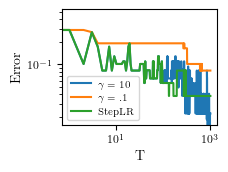

In [7]:
import matplotlib.pyplot as plt
import numpy as np
plt.rc('font', family='serif')
plt.rc('text', usetex=True)

fig, ax = plt.subplots(1, 1, figsize=(2, 1.5))
leg = []
for i in range(num_models):
    # ax.plot(np.arange(nb_epoch)[10:], train_loss[i][10:], color='C' + str(i), alpha=.1, linestyle='--')
    a, = ax.plot(np.arange(nb_epoch), test_loss[i], color= 'C' + str(i))
    leg.append(a)
ax.set_xscale('log')
ax.set_yscale('log')
# ax.set_ylim(3e-2, 1e0)
ax.set_xlabel('T', fontsize=10)
ax.set_ylabel('Error', fontsize=10)
ax.tick_params(axis='both', which='major', labelsize=8)
ax.legend(leg, [r"$\gamma=10$", r"$\gamma=.1$", r"StepLR"], fontsize=7)
fig.savefig('sgd_step_lr.pdf', bbox_inches='tight')

Averaging over several trials

In [ ]:
lrs = [1e1, 1e-1, 1e1]
num_models = len(lrs)

nb_trials = 100

train_loss = th.zeros(num_models, nb_trials, nb_epoch)
test_loss = th.zeros(num_models, nb_trials, nb_epoch)
train_loss[:] = -1
test_loss[:] = -1

for k in range(nb_trials):
    # Embeddings
    E = get_embeddings(n, d, norm=False)
    U = get_embeddings(m, d, norm=True).T 

    # models
    assoc = []
    opti = []
    for i in range(num_models):
        assoc.append(AssMem(E, U))
        lr = lrs[i]
        opti.append(th.optim.SGD(assoc[-1].parameters(), lr=lr, momentum=0))

    for i in range(nb_epoch):
        x = th.multinomial(proba, batch_size, replacement=True)
        y = x % m

        for j in range(num_models):
            out = assoc[j](x)
            loss = F.cross_entropy(out, y)
            train_loss[j, k, i] = loss.item()

            with th.no_grad():
                pred = assoc[j](all_x).argmax(dim=-1)
                test_loss[j, k, i] = proba[pred != all_y].sum().item()

            opti[j].zero_grad()
            loss.backward()
            opti[j].step()

        if i == 100:
            for g in opti[-1].param_groups:
                g['lr'] *= .03

    print(k, end=',')

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,

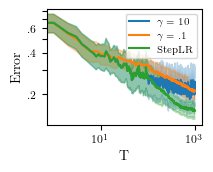

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
plt.rc('font', family='serif')
plt.rc('text', usetex=True)

fig, ax = plt.subplots(1, 1, figsize=(2, 1.5))
leg = []
for i in range(num_models):
    a, = ax.plot(batch_size * np.arange(nb_epoch), test_loss[i].mean(dim=0), color= 'C' + str(i))
    ax.fill_between(batch_size * np.arange(nb_epoch), test_loss[i].mean(dim=0) - .5 * test_loss[i].std(dim=0), test_loss[i].mean(dim=0) + .5 * test_loss[i].std(dim=0), color= 'C' + str(i), alpha=.3)
    leg.append(a)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_yticks([.2, .3, .4, .5, .6, .7, .8])
ax.set_yticklabels(['.2', '', '.4', '', '.6', '', ''])
ax.set_xlabel('T', fontsize=10)
ax.set_ylabel('Error', fontsize=10)
ax.tick_params(axis='both', which='major', labelsize=8)
ax.legend(leg, [r"$\gamma=10$", r"$\gamma=.1$", r"StepLR"], fontsize=7)
fig.savefig('sgd_step_lr_mean.pdf', bbox_inches='tight')